# Анализ поведения пользоваталей в приложении по продаже продуктов питания

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно? После этого исследуйте результаты A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/B-теста. Для него пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Структура исследования:

- открытие данных;
- подготовка данных;
- изучение и проверка данных;
- изучение воронки событий;
- проведенение A/B-тестов;
- формулирование выводов;

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import math as mth
from scipy import stats as st
import warnings

## Шаг 1. Открытие файла изучие общей информации

In [2]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

 #### Таблица - logs:
 - EventName — название события;
 - DeviceIDHash **— уникальный идентификатор пользователя;
 - EventTimestamp — время события;
 - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [3]:
logs.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


#### Вывод: 

Получена таблица с логми пользователей. Объём датасета 4 поля,  244126 строк.


## Шаг 2. Подготовка данных

In [5]:
#переименуем названия столбцов
logs.rename(columns={'EventName': 'event_type', 
                     'DeviceIDHash': 'user_id', 
                     'EventTimestamp': 'event_time_unix',
                     'ExpId':'group'}, inplace=True)

In [6]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event_type         244126 non-null object
user_id            244126 non-null int64
event_time_unix    244126 non-null int64
group              244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [7]:
# ищем дубликаты
logs.duplicated().sum()

413

In [8]:
# удаляем дубликаты
logs = logs.drop_duplicates().reset_index(drop = True)

In [9]:
# переводим в текстовый вид user_id и group
logs['user_id'] = logs['user_id'].astype('str')
logs['group'] = logs['group'].astype('str')

In [10]:
#переводим формат из unix в datetime
logs['event_datetime'] = pd.to_datetime(logs['event_time_unix'], unit='s')

In [11]:
#переводим формат из unix в datetime дни
logs['event_date'] = logs['event_datetime'].astype('datetime64[D]')

#### Вывод:
 - Переимнованы столбцы: EventName': 'event_type',  'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_time_unix', 'ExpId':'group'
 - Удалены дубликаты  - 413 шт.;
 - Переведён в строчный формат: 'user_id', 'group';
 - Создан столбцец с датой и временем 'event_datetime' в формате datetime
 - Создан столбцец с датой 'event_date'

## Шаг 3. Изучите и проверьте данные

#### Сколько всего событий в логе?

In [12]:
#уникальные события в логах
logs['event_type'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [13]:
#количество событий
len(logs['event_type'].unique())

5

#### Сколько в среднем событий приходится на пользователя?

In [14]:
#найдём медиану
logs_event_type = logs.groupby('user_id').agg({'event_type':'count'}).reset_index()
#переименуем столбцы
logs_event_type.set_axis(['user_id', 'event_type_count'], axis = 'columns', inplace = True)
#найдём медиану
logs_event_type['event_type_count'].median()

20.0

####  Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [15]:
#данные с 
logs['event_datetime'].min()

Timestamp('2019-07-25 04:43:36')

In [16]:
# по
logs['event_datetime'].max()

Timestamp('2019-08-07 21:15:17')

In [17]:
# период
logs['event_datetime'].max() - logs['event_datetime'].min()

Timedelta('13 days 16:31:41')

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


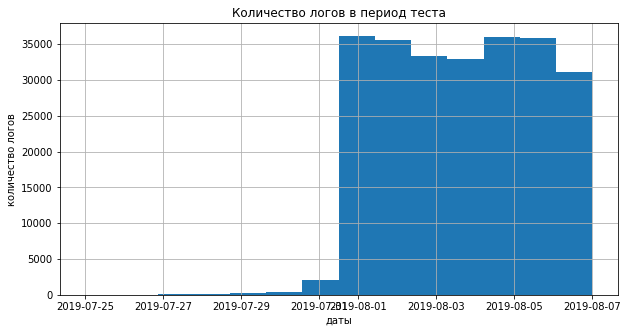

In [18]:
ax = plt.subplots(figsize=(10, 5))

ax = logs['event_date'].hist(bins = 14)

plt.title("Количество логов в период теста")
plt.ylabel("количество логов")
plt.xlabel("даты")
plt.show()

"По оси X даты наезжают друг на друга" - это баг самой гистограммы, почему-то сетка здесь схлопывается.

Мы распологаем полными данными с 1 по 8 августа. Данные до 1 августа отброшенные как не полные.

####  Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [19]:
#количество уникальных пользователей до фильтрации
len(logs['user_id'].unique())

7551

In [20]:
#количество событий до фильтрации
logs.shape[0]

243713

In [21]:
#отфильтровываем данные до 1 августа
logs = logs.query('event_date >= "2019-08-01"')

In [22]:
#количество уникальных пользователей после фильтрации
len(logs['user_id'].unique())

7534

In [23]:
#количество событий после фильтрации
logs.shape[0]

240887

После фильтрации мы потеряли менее 1% уникальных пользователей, и 1.2% логов

####  Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [24]:
logs.groupby('group').agg({'user_id':'nunique'}).reset_index()

,group,user_id
0,246,2484
1,247,2513
2,248,2537


In [25]:
groups = logs.pivot_table(
    index='group', 
    columns='event_type', 
    values='user_id',
    aggfunc='nunique').reset_index()
groups

event_type,group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,1266,2450,1542,1200,278
1,247,1238,2476,1520,1158,283
2,248,1230,2493,1531,1181,279


Пользовататели есть во всех трёх группах и во всех событиях

#### Вывод:
 - Имеются данные в период с 2019-07-25 по 2019-08-07, длительностью -  14 дней;
 - Отфильтровав данные получаем период с 2019-08-01 по 2019-08-07 - 7 дней;
 - После фильтрации мы потеряли менее 1% уникальных пользователей, и 1.2% логов;
 - Пользователи есть во всех трёх экспериментальных группах

## Шаг 4. Изучите воронку событий

####  Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [26]:
#уникальные события в логах
logs['event_type'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

In [27]:
#частота событий
logs.groupby('event_type').agg({'user_id':'count'}).reset_index().sort_values(by = 'user_id', ascending = False)

,event_type,user_id
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


####  Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [28]:
#находим количество уникальных пользователей во всех событиях
event_type_user_unic = logs.groupby('event_type').agg({'user_id':'nunique'}).reset_index().sort_values(by = 'user_id', ascending = False)

In [29]:
#находим долю от общего количества пользователй
event_type_user_unic['proportion'] = round(event_type_user_unic['user_id']/len(logs['user_id'].unique()),2)

In [30]:
event_type_user_unic

,event_type,user_id,proportion
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


####  Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Последовательность событий:
 - Main Screen Appear
 - Offers Screen Appear
 - Cart Screen Appear
 - Payment Screen Successful
 
 
Отельное событие:
 - Tutorial

####  По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C, посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A.

In [31]:
users = logs.pivot_table(
    index='user_id', 
    columns='event_type', 
    values='event_datetime',
    aggfunc='min').reset_index()

users = users[['user_id', 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']]
#сообщить о временных сбоях!
users.head(5)

event_type,user_id,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
0,1000608915523616548,2019-08-01 16:05:50,2019-08-07 16:15:07,NaT,NaT
1,100724994572555335,2019-08-05 16:06:45,NaT,NaT,NaT
2,1008242126838007188,2019-08-01 09:32:21,2019-08-01 09:32:29,2019-08-01 09:32:23,2019-08-01 09:32:23
3,1009503747199967885,2019-08-04 16:34:04,2019-08-04 16:30:26,2019-08-05 09:59:26,2019-08-05 09:59:25
4,1009745980451513098,2019-08-01 15:28:01,2019-08-01 15:38:05,2019-08-01 15:29:00,2019-08-02 16:36:07


In [32]:
#находим количество пользователей для каждого события
step_1 = ~users['MainScreenAppear'].isna()
step_2 = ~users['OffersScreenAppear'].isna()
step_3 = ~users['CartScreenAppear'].isna()
step_4 = ~users['PaymentScreenSuccessful'].isna()


n_main = users[step_1].shape[0]
n_offers = users[step_2].shape[0]
n_add_to_cart = users[step_3].shape[0]
n_payment = users[step_4].shape[0]


print('Главный экран:', n_main)
print('Товары:', n_offers)
print('Добавили товара в корзину:', n_add_to_cart)
print('Оплатили:', n_payment)

Главный экран: 7419
Товары: 4593
Добавили товара в корзину: 3734
Оплатили: 3539


In [33]:
#Товары/Главный экран
round(n_offers/n_main,2)

0.62

In [34]:
#Добавили товара в корзину/Товары
round(n_add_to_cart/n_offers,2)

0.81

In [35]:
#Оплатили/Добавили товара в корзину
round(n_payment/n_add_to_cart,2)

0.95

Доля переходов:
- OffersScreenAppear / MainScreenAppear: 0.62
- CartScreenAppear / OffersScreenAppear: 0.81
- PaymentScreenSuccessful / CartScreenAppear: 0.95

####   На каком шаге теряете больше всего пользователей?

OffersScreenAppear / MainScreenAppear

####  Какая доля пользователей доходит от первого события до оплаты?

In [36]:
round(n_payment/n_main,2)

0.48

#### Вывод:

Доля переходов в событиях:

- OffersScreenAppear / MainScreenAppear: 0.62
- CartScreenAppear / OffersScreenAppear: 0.81
- PaymentScreenSuccessful / CartScreenAppear: 0.95
 
Больше всего пользователей теряется на шаге:  OffersScreenAppear / MainScreenAppear

Доля пользователей которая доходит от первого события до оплаты: 48%
 

## Шаг 5. Изучите результаты эксперимента

####  Сколько пользователей в каждой экспериментальной группе?

In [37]:
logs.groupby('group').agg({'user_id':'nunique'}).reset_index()

,group,user_id
0,246,2484
1,247,2513
2,248,2537


####  Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

Сформулируем гипотезу:
 - H0: Нет значимой разницы в долях конверссии двух групп;
 - H1: Есть разница в долях конверссии двух групп;

In [38]:
#находим количество уникальных событий для 246 гуппы
users_246 = logs.query('group == "246"').pivot_table(
    index='user_id', 
    columns='event_type', 
    values='event_datetime',
    aggfunc='min').reset_index()

#перегрупировываем столбцы 
users_246 = users_246[['user_id', 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']]

#находим количество пользователей для каждого события
step_1 = ~users_246['MainScreenAppear'].isna()
step_2 = ~users_246['OffersScreenAppear'].isna()
step_3 = ~users_246['CartScreenAppear'].isna()
step_4 = ~users_246['PaymentScreenSuccessful'].isna()


n_main_246 = users_246[step_1].shape[0]
n_offers_246 = users_246[step_2].shape[0]
n_add_to_cart_246 = users_246[step_3].shape[0]
n_payment_246 = users_246[step_4].shape[0]

print('Главный экран:', n_main_246)
print('Товары:', n_offers_246)
print('Добавили товара в корзину:', n_add_to_cart_246)
print('Оплатили:', n_payment_246)

Главный экран: 2450
Товары: 1542
Добавили товара в корзину: 1266
Оплатили: 1200


In [39]:
#находим количество уникальных событий для 247 гуппы
users_247 = logs.query('group == "247"').pivot_table(
    index='user_id', 
    columns='event_type', 
    values='event_datetime',
    aggfunc='min').reset_index()

#перегрупировываем столбцы 
users_247 = users_247[['user_id', 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']]

#находим количество пользователей для каждого события
step_1 = ~users_247['MainScreenAppear'].isna()
step_2 = ~users_247['OffersScreenAppear'].isna()
step_3 = ~users_247['CartScreenAppear'].isna()
step_4 = ~users_247['PaymentScreenSuccessful'].isna()


n_main_247 = users_247[step_1].shape[0]
n_offers_247 = users_247[step_2].shape[0]
n_add_to_cart_247 = users_247[step_3].shape[0]
n_payment_247 = users_247[step_4].shape[0]

print('Главный экран:', n_main_247)
print('Товары:', n_offers_247)
print('Добавили товара в корзину:', n_add_to_cart_247)
print('Оплатили:', n_payment_247)

Главный экран: 2476
Товары: 1520
Добавили товара в корзину: 1238
Оплатили: 1158


In [40]:
alpha = .05 # критический уровень статистической значимости

# пропорция успехов в первой группе:
p246 = n_payment_246/n_main_246

# пропорция успехов во второй группе:
p247 = n_payment_247/n_main_247

# пропорция успехов в комбинированном датасете:
p_combined = (n_payment_246 + n_payment_247) / (n_main_246 + n_main_247)

# разница пропорций в датасетах
difference = p246 - p247

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n_main_246 + 1/n_main_247))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.12044299485641763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


A/A-тест показал что нет статистически значимой разницы между выборками 246 и 247( p-значение: 0.12, H0). Можно приступать к А/B-тесту.

####  Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

#### A(246)/A(247)

Сформулируем гипотезу:
 - H0: Нет значимой разницы в долях по типу события между двумя группами;
 - H1: Есть разница в долях по типу события между двух групп;

In [41]:
#находим количество уникальных событий для 246 и 247 гупп
users_aa = logs.query('group == "246" | group == "247"').pivot_table(
    index='event_type', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').reset_index()

In [42]:
#нахом количество уникальных пользователей для каждой группы
users_aa['user_unique_246'] = len(logs.query('group == "246"')['user_id'].unique())
users_aa['user_unique_247'] = len(logs.query('group == "247"')['user_id'].unique())

In [43]:
#функция z-теста
def z_test_group(row):   
    alpha = .05/20 # критический уровень статистической значимости c коррекцией

    # пропорция успехов в первой группе:
    p1 = row[1]/row[3]

    # пропорция успехов во второй группе:
    p2 = row[2]/row[4]

    # пропорция успехов в комбинированном датасете:
    p_combined = (row[1] + row[2]) / (row[3] + row[4])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/row[3] + 1/row[4]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2


    if (p_value < alpha):
        return  "H1"  'p-значение: ', round(p_value, 3)
    else:
        return "H0 - " 'p-значение: ', round(p_value, 3)

In [44]:
#применяем функцию z_test_group
users_aa['aa_test'] = users_aa.apply(z_test_group, axis = 1)

#сортируем по убыванию
users_aa.sort_values(by = "246", ascending = False).reset_index(drop = True)

group,event_type,246,247,user_unique_246,user_unique_247,aa_test
0,MainScreenAppear,2450,2476,2484,2513,"(H0 - p-значение: , 0.757)"
1,OffersScreenAppear,1542,1520,2484,2513,"(H0 - p-значение: , 0.248)"
2,CartScreenAppear,1266,1238,2484,2513,"(H0 - p-значение: , 0.229)"
3,PaymentScreenSuccessful,1200,1158,2484,2513,"(H0 - p-значение: , 0.115)"
4,Tutorial,278,283,2484,2513,"(H0 - p-значение: , 0.938)"


Нет статистически значимых различий между группами 246 и 247 по каждому типу события 

####  Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

#### A(246)/B(248)

Сформулируем гипотезу:
 - H0: Нет значимой разницы в долях по типу события между двумя группами;
 - H1: Есть разница в долях по типу события между двух групп;

In [45]:
#находим количество уникальных пользователей по каждому типу событя в двух группах
users_246_248 = logs.query('group == "246" | group == "248"').pivot_table(
    index='event_type', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').reset_index()

In [46]:
#нахом количество уникальных пользователей для каждой группы
users_246_248['user_unique_246'] = len(logs.query('group == "246"')['user_id'].unique())
users_246_248['user_unique_248'] = len(logs.query('group == "248"')['user_id'].unique())

In [47]:
#применяем функцию z_test_group
users_246_248['aa_test'] = users_246_248.apply(z_test_group, axis = 1)
#сортируем по убыванию
users_246_248.sort_values(by = "246", ascending = False).reset_index(drop = True)

group,event_type,246,248,user_unique_246,user_unique_248,aa_test
0,MainScreenAppear,2450,2493,2484,2537,"(H0 - p-значение: , 0.295)"
1,OffersScreenAppear,1542,1531,2484,2537,"(H0 - p-значение: , 0.208)"
2,CartScreenAppear,1266,1230,2484,2537,"(H0 - p-значение: , 0.078)"
3,PaymentScreenSuccessful,1200,1181,2484,2537,"(H0 - p-значение: , 0.212)"
4,Tutorial,278,279,2484,2537,"(H0 - p-значение: , 0.826)"


Нет статистически значимых различий между группами 246 и 248 по каждому типу события

#### A(247)/B(248)

Сформулируем гипотезу:
 - H0: Нет значимой разницы в долях по типу события между двумя группами;
 - H1: Есть разница в долях по типу события между двух групп;

In [48]:
#находим количество уникальных пользователей по каждому типу событя в двух группах
users_247_248 = logs.query('group == "247" | group == "248"').pivot_table(
    index='event_type', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').reset_index()

In [49]:
#нахом количество уникальных пользователей для каждой группы
users_247_248['user_unique_247'] = len(logs.query('group == "247"')['user_id'].unique())
users_247_248['user_unique_248'] = len(logs.query('group == "248"')['user_id'].unique())

In [50]:
#применяем функцию z_test_group
users_247_248['aa_test'] = users_247_248.apply(z_test_group, axis = 1)
#сортируем по убыванию
users_247_248.sort_values(by = "247", ascending = False).reset_index(drop = True)

group,event_type,247,248,user_unique_247,user_unique_248,aa_test
0,MainScreenAppear,2476,2493,2513,2537,"(H0 - p-значение: , 0.459)"
1,OffersScreenAppear,1520,1531,2513,2537,"(H0 - p-значение: , 0.92)"
2,CartScreenAppear,1238,1230,2513,2537,"(H0 - p-значение: , 0.579)"
3,PaymentScreenSuccessful,1158,1181,2513,2537,"(H0 - p-значение: , 0.737)"
4,Tutorial,283,279,2513,2537,"(H0 - p-значение: , 0.765)"


Нет статистически значимых различий между группами 247 и 248 по каждому типу события

#### A(246+247)/B(248)

Сформулируем гипотезу:
 - H0: Нет значимой разницы в долях по типу события между двумя группами;
 - H1: Есть разница в долях по типу события между двух групп;

In [51]:
#объединяем группы 246 и 247 в единую группу А
def re_type_groupe(row):
    if row == "246" or row == "247":
        return "A"
    else:
        return "B"

In [52]:
#применяем функцию re_type_groupe
logs['new_group'] = logs['group'].apply(re_type_groupe)

warnings.filterwarnings('ignore')

In [53]:
#находим количество уникальных пользователей по каждому типу событя в двух группах
users_ab = logs.pivot_table(
    index='event_type', 
    columns='new_group', 
    values='user_id',
    aggfunc='nunique').reset_index()

In [54]:
#нахом количество уникальных пользователей для каждой группы
users_ab['user_unique_A'] = len(logs.query('new_group == "A"')['user_id'].unique())
users_ab['user_unique_B'] = len(logs.query('new_group == "B"')['user_id'].unique())

In [55]:
#применяем функцию z_test_group
users_ab['ab_test'] = users_ab.apply(z_test_group, axis = 1)
#сортируем по убыванию
users_ab.sort_values(by = "A", ascending = False).reset_index(drop = True)

new_group,event_type,A,B,user_unique_A,user_unique_B,ab_test
0,MainScreenAppear,4926,2493,4997,2537,"(H0 - p-значение: , 0.294)"
1,OffersScreenAppear,3062,1531,4997,2537,"(H0 - p-значение: , 0.434)"
2,CartScreenAppear,2504,1230,4997,2537,"(H0 - p-значение: , 0.182)"
3,PaymentScreenSuccessful,2358,1181,4997,2537,"(H0 - p-значение: , 0.6)"
4,Tutorial,561,279,4997,2537,"(H0 - p-значение: , 0.765)"


Нет статистически значимых различий между группами A и B по каждому типу события (p-значение от 0.18 до 0.77)

####  Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

В тесте поведение пользователей определяется воронкой, которая описывается долями пользователей, завершивших каждый шаг воронки. Поэтому группы можно сравнить z-тестами. Уровень значимости был выбран 0.0025% т. к. у нас двухстронний z-тест, и скорректирован т.к. множественный тест(4 теста по 5 событий)

### Вывод:

 - Количество пользователей в каждой группе: 246 - 2484, 247 - 2513, 248 - 2537;
 - A/A-тест показал что нет статистически значимой разницы между выборками 246 и 247( p-значение: 0.12, H0). Можно приступать к А/B-тесту;
 - Нет статистически значимых различий между группами 246 и 247 по каждому типу события (p-значение от 0.12 до 0.94);
 - Нет статистически значимых различий между группами 246 и 248 по каждому типу события (p-значение от 0.08 до 0.83);
 - Нет статистически значимых различий между группами 247 и 248 по каждому типу события (p-значение от 0.46 до 0.77);
 - Нет статистически значимых различий между группами A и B по каждому типу события (p-значение от 0.18 до 0.77);
 - В тесте поведение пользователей определяется воронкой, которая описывается долями пользователей, завершивших каждый шаг воронки. Поэтому группы можно сравнить z-тестами. Уровень значимости был выбран 0.0025% т.к. у нас двухстронний z-тест, и скорректирован т.к. множественный тест(4 теста по 5 событий).

## Общий вывод:

 - Получена таблица с логми пользователей. Объём датасета 4 поля,  244126 строк;
 - Переимнованы столбцы: EventName': 'event_type',  'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_time_unix', 'ExpId':'group';
 - Удалены дубликаты  - 413 шт.;
 - Переведён в строчный формат: 'user_id', 'group';
 - Создан столбцец с датой и временем 'event_datetime' в формате datetime;
 - Создан столбцец с датой 'event_date';


 - Имеются данные в период с 2019-07-25 по 2019-08-07, длительностью -  14 дней;
 - Отфильтровав данные получили период с 2019-08-01 по 2019-08-07 - 7 дней;
 - После фильтрации мы потеряли менее 1% уникальных пользователей, и 1.2% логов;
 - Пользователи есть во всех трёх экспериментальных группах;
 - уникальные события: Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful;



 - Доля переходов в событиях: OffersScreenAppear / MainScreenAppear: 0.57, CartScreenAppear / OffersScreenAppear: 0.42, PaymentScreenSuccessful / CartScreenAppear: 0.26; 
 - Больше всего пользователей теряется на шаге:  OffersScreenAppear / MainScreenAppear (57%); 
 - Доля пользователей которая доходит от первого события до оплаты: 6%
 
 
 - Количество пользователей в каждой группе: 246 - 2484, 247 - 2513, 248 - 2537;
 - A/A-тест показал что нет статистически значимой разницы между выборками 246 и 247( p-значение: 0.88, H0). Можно приступать к А/B-тесту;
 - Нет статистически значимых различий между группами 246 и 247 по каждому типу события (p-значение от 0.12 до 0.94);
 - Нет статистически значимых различий между группами 246 и 248 по каждому типу события (p-значение от 0.08 до 0.83);
 - Нет статистически значимых различий между группами 247 и 248 по каждому типу события (p-значение от 0.46 до 0.77);
 - Нет статистически значимых различий между группами A и B по каждому типу события (p-значение от 0.18 до 0.77);
 - В тесте поведение пользователей определяется воронкой, которая описывается долями пользователей, завершивших каждый шаг воронки. Поэтому группы можно сравнить z-тестами. Уровень значимости был выбран 0.0025% т.к. у нас двухстронний z-тест, и скорректирован т.к. множественный тест(4 теста по 5 событий);
 
#### Вывод: 
 - дизайнеры могут поменять шрифт в мобильном приложении, он не влияет на конверсию покупателей.
 